<a href="https://colab.research.google.com/github/benmaalladoaae7324encg-stack/24010362-benmaalla-doaae/blob/main/Copie%20de%20%20football%20player%20and%20object%20detection%20with%20yolvo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# INSTALL PACKAGES FIRST
# ============================================================================
import subprocess
import sys

def install_packages():
    """Install required packages"""
    packages = [
        'ipywidgets',
        'ultralytics',
        'torch',
        'torchvision',
        'torchaudio'
    ]

    print("Installing required packages...")
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

    # Disable wandb
    subprocess.run(['wandb', 'disabled'], capture_output=True)
    print("All packages installed successfully!")

# Run installation
install_packages()

# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd
import os
import warnings
import random
import cv2
import matplotlib.pyplot as plt
import shutil
from IPython.display import HTML, display
from base64 import b64encode

# Suppress warnings
warnings.filterwarnings("ignore", message=".*will create.*worker processes.")
warnings.filterwarnings("ignore", message="os.fork() was called.*")
os.environ['OMP_NUM_THREADS'] = '1'

# Configure multiprocessing
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

from ultralytics import YOLO

print("All packages imported successfully!")

# ============================================================================
# DATA SETUP
# ============================================================================
print("\n" + "="*70)
print("DATA SETUP INSTRUCTIONS")
print("="*70)
print("""
For this notebook to work, you need to upload your data. Choose one option:

OPTION 1: Mount Google Drive (Recommended)
-----------------------------------------
Run this code in a new cell:
    from google.colab import drive
    drive.mount('/content/drive')

Then set your paths:
    yaml_path = "/content/drive/MyDrive/your_dataset/data.yaml"
    val_images_dir = "/content/drive/MyDrive/your_dataset/valid/images"
    input_video_path = "/content/drive/MyDrive/your_video.mp4"

OPTION 2: Upload Files Directly
-------------------------------
Run this code in a new cell:
    from google.colab import files
    uploaded = files.upload()

OPTION 3: Download from URL
---------------------------
Run in a new cell:
    !wget YOUR_DATASET_URL -O dataset.zip
    !unzip dataset.zip
""")

# CONFIGURE YOUR PATHS HERE
yaml_path = "/content/data.yaml"
val_images_dir = "/content/valid/images"
input_video_path = "/content/video.mp4"

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("\nRunning in Google Colab")
except:
    IN_COLAB = False
    print("\nNot running in Google Colab")

# ============================================================================
# EXPLORE DATA (Optional)
# ============================================================================
print("\n" + "="*70)
print("CURRENT DIRECTORY CONTENTS")
print("="*70)

for dirname, _, filenames in os.walk('/content'):
    for filename in filenames[:10]:
        print(os.path.join(dirname, filename))
    if len(filenames) > 10:
        print(f"... and {len(filenames) - 10} more files")
    break

# ============================================================================
# MODEL TRAINING
# ============================================================================
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

if not os.path.exists(yaml_path):
    print(f"WARNING: data.yaml not found at {yaml_path}")
    print("Please upload your dataset and update the yaml_path variable")
else:
    model = YOLO("yolov8n.pt")
    model.info()

    print("\nStarting training...")
    results = model.train(
        data=yaml_path,
        epochs=15,
        verbose=True,
        imgsz=640,
        batch=16,
        device=0 if IN_COLAB else 'cpu'
    )
    print("Training completed!")

# ============================================================================
# MODEL VALIDATION
# ============================================================================
print("\n" + "="*70)
print("MODEL VALIDATION")
print("="*70)

if os.path.exists(yaml_path):
    results = model.val(data=yaml_path)

    try:
        metrics = results.box
        map_50 = metrics.map50
        map_50_95 = metrics.map
        precision = metrics.mp
        recall = metrics.mr

        if (precision + recall) != 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0

        print(f"\n{'='*50}")
        print(f"VALIDATION METRICS")
        print(f"{'='*50}")
        print(f"Precision:       {precision:.4f}")
        print(f"Recall:          {recall:.4f}")
        print(f"F1 Score:        {f1:.4f}")
        print(f"mAP@0.5:         {map_50:.4f}")
        print(f"mAP@0.5:0.95:    {map_50_95:.4f}")
        print(f"{'='*50}")

    except Exception as e:
        print(f"WARNING: Error extracting metrics: {e}")
        print("Results object:", results)

# ============================================================================
# INFERENCE ON VALIDATION IMAGES
# ============================================================================
print("\n" + "="*70)
print("INFERENCE ON RANDOM VALIDATION IMAGES")
print("="*70)

if os.path.exists(val_images_dir):
    model_path = '/content/runs/detect/train/weights/best.pt'

    if os.path.exists(model_path):
        model = YOLO(model_path)
        print(f"Loaded trained model from {model_path}")
    else:
        model = YOLO('yolov8n.pt')
        print("WARNING: Using pretrained model (trained model not found)")

    all_images = [f for f in os.listdir(val_images_dir)
                  if os.path.isfile(os.path.join(val_images_dir, f))
                  and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(all_images) > 0:
        num_images = min(10, len(all_images))
        selected_images = random.sample(all_images, num_images)

        def display_image_with_predictions(image_path, predictions):
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            for pred in predictions:
                x1, y1, x2, y2, conf, cls = pred
                label = f"{model.names[int(cls)]} {conf:.2f}"
                cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(img, label, (int(x1), int(y1)-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.title(os.path.basename(image_path))
            plt.show()

        print(f"\nDisplaying {num_images} random validation images with predictions:\n")
        for img_name in selected_images:
            img_path = os.path.join(val_images_dir, img_name)
            results = model(img_path)
            display_image_with_predictions(img_path, results[0].boxes.data.cpu().numpy())
    else:
        print(f"WARNING: No images found in {val_images_dir}")
else:
    print(f"WARNING: Validation directory not found: {val_images_dir}")

# ============================================================================
# VIDEO INFERENCE
# ============================================================================
print("\n" + "="*70)
print("VIDEO INFERENCE")
print("="*70)

def display_video(video_path, width=None, height=None):
    if not os.path.exists(video_path):
        print(f"WARNING: Video not found: {video_path}")
        return

    with open(video_path, 'rb') as f:
        video_data = f.read()

    video_encoded = b64encode(video_data).decode()
    data_url = f"data:video/mp4;base64,{video_encoded}"

    width_attr = f'width="{width}"' if width else ''
    height_attr = f'height="{height}"' if height else ''

    html_video = HTML(f"""
    <video controls {width_attr} {height_attr}>
          <source src="{data_url}" type="video/mp4">
          Your browser does not support the video tag.
    </video>
    """)

    display(html_video)

if os.path.exists(input_video_path):
    model_path = '/content/runs/detect/train/weights/best.pt'

    if os.path.exists(model_path):
        model = YOLO(model_path)
        print(f"Loaded trained model from {model_path}")
    else:
        model = YOLO('yolov8n.pt')
        print("WARNING: Using pretrained model (trained model not found)")

    output_dir = '/content/annotated_frames'
    output_path = '/content/output_video.mp4'

    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"\nVideo properties:")
    print(f"  FPS: {fps}")
    print(f"  Resolution: {width}x{height}")

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    print(f"\nCreated output directory: {output_dir}")

    frame_index = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"\nProcessing {total_frames} frames...")

    while cap.isOpened():
        ret, input_image = cap.read()
        if not ret:
            break

        results = model.predict(input_image, imgsz=640, conf=0.25, verbose=False)
        annotated_image = results[0].plot()

        annotated_frame_path = os.path.join(output_dir, f'frame_{frame_index:05d}.jpg')
        cv2.imwrite(annotated_frame_path, annotated_image)
        frame_index += 1

        if frame_index % 30 == 0:
            print(f"  Processed {frame_index}/{total_frames} frames...")

    cap.release()
    print(f"\nProcessed all {frame_index} frames")

    print("\nCreating output video...")
    ffmpeg_cmd = f'ffmpeg -y -framerate {fps} -i {output_dir}/frame_%05d.jpg -c:v libx264 -pix_fmt yuv420p -an {output_path}'
    os.system(ffmpeg_cmd)

    if os.path.exists(output_path):
        print(f"Video processing complete!")
        print(f"  Output saved to: {output_path}")
        print("\nDisplaying annotated video:")
        display_video(output_path, width=640, height=360)
    else:
        print("WARNING: Error creating output video")
else:
    print(f"WARNING: Input video not found: {input_video_path}")
    print("\nTo process a video:")
    print("1. Upload your video to Colab")
    print("2. Update the 'input_video_path' variable")
    print("3. Run this section again")

# ============================================================================
# COMPLETION
# ============================================================================
print("\n" + "="*70)
print("SCRIPT EXECUTION COMPLETED")
print("="*70)
print("""
Summary:
- All installations completed
- Model training/validation completed (if data was available)
- Inference on images completed (if images were available)
- Video processing completed (if video was available)

Next Steps:
- Review the validation metrics
- Check the annotated images and video
- Adjust hyperparameters if needed
- Export the model for deployment

For questions or issues, refer to:
- Ultralytics Documentation: https://docs.ultralytics.com/
- YOLOv8 GitHub: https://github.com/ultralytics/ultralytics
""")


Installing required packages...
Installing ipywidgets...
Installing ultralytics...
Installing torch...
Installing torchvision...
Installing torchaudio...
All packages installed successfully!
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
All packages imported successfully!

DATA SETUP INSTRUCTIONS

For this notebook to work, you need to upload your data. Choose one option:

OPTION 1: Mount Google Drive (Recommended)
-----------------------------------------
Run this code in a new cell:
    from google.colab import drive
    drive.mount('/content/drive')

Then set your paths:
    yaml_path = "/content/drive/MyDrive/your_dataset/data.yaml"
    val_images_dir = "/content/drive/MyDrive/your_dataset/valid/images"
    input_video_pa


Régression Linéaire


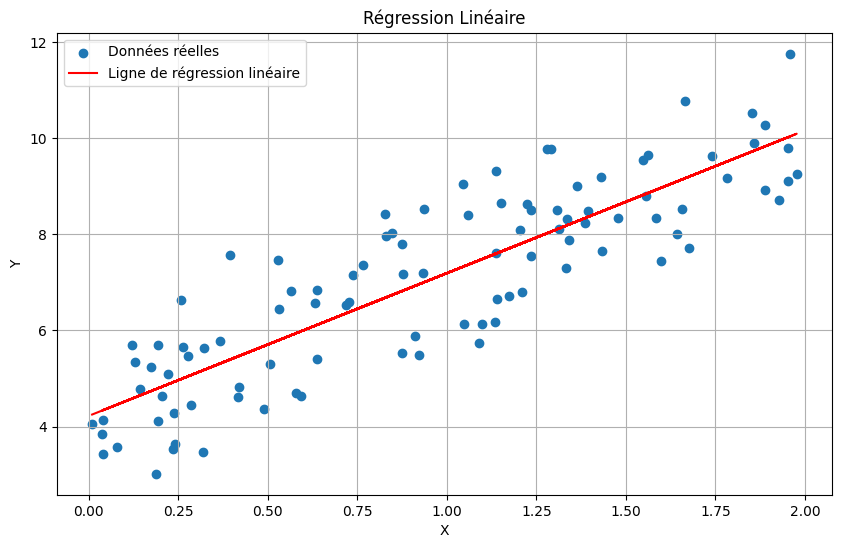


Coefficient (pente): 2.97
Ordonnée à l'origine: 4.22
Erreur quadratique moyenne (MSE): 0.99

Régression Logistique


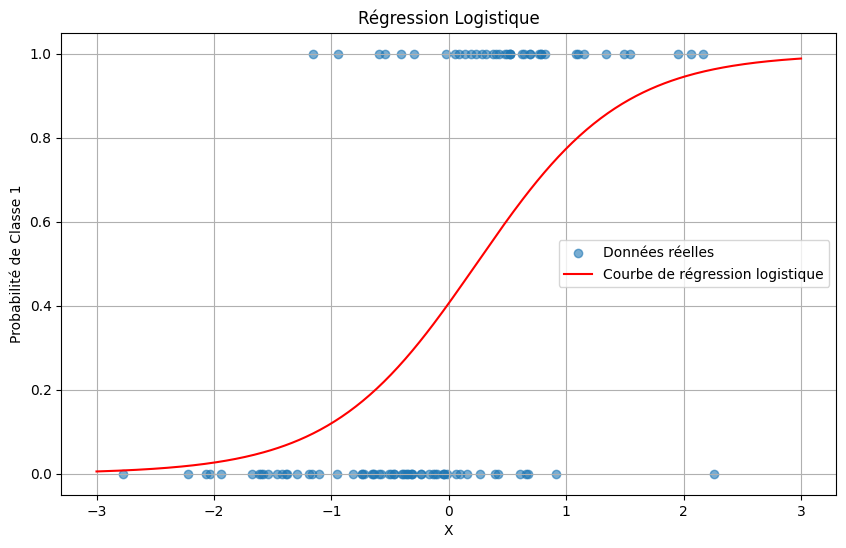


Précision du modèle: 0.80


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

print("\n=========================================")
print("Régression Linéaire")
print("=========================================")

# Génération de données synthétiques pour la régression linéaire
np.random.seed(0)
X_linear = 2 * np.random.rand(100, 1)
y_linear = 4 + 3 * X_linear + np.random.randn(100, 1)

# Création et entraînement du modèle de régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_linear, y_linear)

# Prédictions
y_linear_pred = lin_reg.predict(X_linear)

# Affichage du graphique de régression linéaire
plt.figure(figsize=(10, 6))
plt.scatter(X_linear, y_linear, label='Données réelles')
plt.plot(X_linear, y_linear_pred, color='red', label='Ligne de régression linéaire')
plt.title('Régression Linéaire')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nCoefficient (pente): {lin_reg.coef_[0][0]:.2f}")
print(f"Ordonnée à l'origine: {lin_reg.intercept_[0]:.2f}")
print(f"Erreur quadratique moyenne (MSE): {mean_squared_error(y_linear, y_linear_pred):.2f}")

print("\n=========================================")
print("Régression Logistique")
print("=========================================")

# Génération de données synthétiques pour la régression logistique
X_logistic = np.random.randn(100, 1)
y_logistic = (X_logistic > 0).astype(int).flatten()

# Ajout de bruit pour rendre la classification moins parfaite
mask_noise = np.random.rand(100) < 0.2
y_logistic[mask_noise] = 1 - y_logistic[mask_noise]

# Création et entraînement du modèle de régression logistique
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_logistic, y_logistic)

# Prédictions de probabilités
X_test = np.linspace(-3, 3, 300).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Affichage du graphique de régression logistique
plt.figure(figsize=(10, 6))
plt.scatter(X_logistic, y_logistic, label='Données réelles', alpha=0.6)
plt.plot(X_test, y_proba, color='red', label='Courbe de régression logistique')
plt.title('Régression Logistique')
plt.xlabel('X')
plt.ylabel('Probabilité de Classe 1')
plt.legend()
plt.grid(True)
plt.show()

# Prédictions de classe et score de précision
y_logistic_pred = log_reg.predict(X_logistic)
print(f"\nPrécision du modèle: {accuracy_score(y_logistic, y_logistic_pred):.2f}")
